In [39]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste as pst
import scanpy as sc
import anndata
# from sklearn.decomposition import NMF
# import scanorama
import os
import diopy
style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

##### WARNING: IF YOU ARE USING A VERSION OF PASTE THAT IS >v1.1.4 YOU MIGHT RUN INTO SOME SMALL ISSUES ############
########## ONE KNOWN ISSUE IS THAT THE INTERSECT FUNCTION IS NOT EXPORTED, an easy fix is to just do: 
from paste.helper import intersect

In [40]:
path_to_output_dir = '../data/SCC/cached-results/'

#if not os.path.exists(path_to_output_dir):
#    os.makedirs(path_to_output_dir)

# Read in Data and Cache Adata

Saving it as .h5ad will make it faster to load the second time around.

In [41]:
def load_layer(patient, sample, metadata):
    """
    Return Layer object of Patient, Sample
    """
    layer_path = f"../data/SCC/scc_p{patient}_layer{sample}"
    layer = layer_path + ".tsv"
    coor_path = layer_path + "_coordinates.tsv"
    adata = anndata.read_csv(layer, delimiter="\t")

    # Data pre-processing
    coor = pd.read_csv(coor_path, sep="\t").iloc[:,:2]
    coor_index = []
    for pair in coor.values:
        coor_index.append('x'.join(str(e) for e in pair))
    coor.index = coor_index
    # The metadata, coordinates, and gene expression might have missing cells between them
    idx = intersect(coor_index, adata.obs.index)
    
    df = metadata[metadata['patient'] == patient]
    df = df[df['sample'] == sample]
    
    meta_idx = []
    for i in df.index:
        meta_idx.append(i.split('_')[1])
    idx = intersect(idx, meta_idx)
    
    adata = adata[idx, :]
    adata.obsm['spatial'] = np.array(coor.loc[idx, :])
    metadata_idx = ['P' + str(patient) + '_' + i + '_' + str(sample) for i in idx]
    adata.obs['original_clusters'] = [str(x) for x in list(metadata.loc[metadata_idx, 'SCT_snn_res.0.8'])]
    return adata

In [42]:
metadata_path =  "../data/SCC/ST_all_metadata.txt"
metadata = pd.read_csv(metadata_path, sep="\t", index_col=0)

adata_2_1 = load_layer(2, 1, metadata)
adata_2_2 = load_layer(2, 2, metadata)
adata_2_3 = load_layer(2, 3, metadata)
patient_2 = [adata_2_1, adata_2_2, adata_2_3]

adata_5_1 = load_layer(5, 1, metadata)
adata_5_2 = load_layer(5, 2, metadata)
adata_5_3 = load_layer(5, 3, metadata)
patient_5 = [adata_5_1, adata_5_2, adata_5_3]

adata_9_1 = load_layer(9, 1, metadata)
adata_9_2 = load_layer(9, 2, metadata)
adata_9_3 = load_layer(9, 3, metadata)
patient_9 = [adata_9_1, adata_9_2, adata_9_3]

adata_10_1 = load_layer(10, 1, metadata)
adata_10_2 = load_layer(10, 2, metadata)
adata_10_3 = load_layer(10, 3, metadata)
patient_10 = [adata_10_1, adata_10_2, adata_10_3]

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for p in patients.values():
    for adata in p:
        sc.pp.filter_genes(adata, min_cells = 15, inplace = True)
        sc.pp.filter_cells(adata, min_genes = 100, inplace = True)

In [43]:
H5ADs_dir = path_to_output_dir + 'H5ADs/'

if not os.path.exists(H5ADs_dir):
    os.makedirs(H5ADs_dir)
    
for k, p in patients.items():
    for i in range(len(p)):
        diopy.output.write_h5(p[i],file= (H5ADs_dir + k + '_slice_' + str(i) + '.h5'))
        p[i].write(H5ADs_dir + k + '_slice_' + str(i) + '.h5ad')

# Pairwise Alignment Experiment

## Define Functions

Calculate percent of original clusters preserved between layers based on pairwise alignment.

In [11]:
def pairwise_exp(adata1, adata2):
    
    # Run pairwise align
    pi = pst.pairwise_align(adata1, adata2, alpha = 0.1)
    
    spotsA, spotsB = np.nonzero(pi)
    s = 0
    for i in range(len(spotsA)):
        # get the clusters corresponding to each spot
        a = adata1.obs['original_clusters'][spotsA[i]]
        b = adata2.obs['original_clusters'][spotsB[i]]
        if a == b:
            s += pi[spotsA[i]][spotsB[i]]
    return s

## Read in Data and Run Experiment

Uncomment the following cells to regenerate the experimental results.

In [12]:
# path_to_h5ads = path_to_output_dir + 'H5ADs/'

# patient_2 = []
# patient_5 = []
# patient_9 = []
# patient_10 = []

# patients = {
#     "patient_2" : patient_2,
#     "patient_5" : patient_5,
#     "patient_9" : patient_9,
#     "patient_10" : patient_10,
# }

# for k in patients.keys():
#     for i in range(3):
#         patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

In [13]:
# df = pd.DataFrame()
# for k, patient_n in patients.items():
#     a = pairwise_exp(patient_n[0].copy(), patient_n[1].copy())
#     b = pairwise_exp(patient_n[1].copy(), patient_n[2].copy())
#     df[k] = [a, b]

In [14]:
# df

In [15]:
# results_dir = path_to_output_dir + 'results/'

# if not os.path.exists(results_dir):
#     os.makedirs(results_dir)

In [16]:
# df.to_csv(results_dir + 'pairwise_results.csv')

## Plot Pairwise Results

In [17]:
results_dir = path_to_output_dir + 'results/'
df = pd.read_csv(results_dir + 'pairwise_results.csv', index_col = 0)

In [18]:
df

,patient_2,patient_5,patient_9,patient_10
0,0.719589,0.273168,0.242048,0.591831
1,0.684851,0.353965,0.251449,0.477576


In [19]:
scores = df.melt()['value'].values
colors = ["#8766c4", "#dda0dd"]
bar_label = 4*['Slice A, Slice B', 'Slice B, Slice C']
labels = 2*['Patient 2'] + 2*['Patient 5'] + 2*['Patient 9'] +2*['Patient 10']
ax2 = sns.barplot(x=labels, y = scores, hue=bar_label, palette=sns.color_palette(colors))
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')  
ax2.set_ylabel("Proportion of Spots Correctly \n Mapped within Clusters", fontsize = 14)
ax2.set_ylim(-0.05,1)
plt.legend(frameon=True, edgecolor='black', fontsize = 12)

Error in callback <function _draw_all_if_interactive at 0x000002A975FA9D80> (for post_execute):


TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 640x480 with 1 Axes>

# Center Alignment Experiment

## Read in Data

In [ ]:
path_to_h5ads = path_to_output_dir + 'H5ADs/'

patient_2 = []
patient_5 = []
patient_9 = []
patient_10 = []

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for k in patients.keys():
    for i in range(3):
        patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

## Plot clusters

We provide an alternative to scanpy .

In [ ]:
def plot_clusters(adata, col, title = ''):
    """
    Plots spatial data with cluster labels stored in adata.obs[col]
    """
    x = adata.obsm['spatial'][:, 0]
    y = adata.obsm['spatial'][:, 1]
    label = adata.obs[col]
    n_colors = len(np.unique(label))
    palette = sns.color_palette("Paired", n_colors)
    plt.figure(figsize= (5, 5))
    ax = sns.scatterplot(x=x, y=y, hue=label, legend="full", palette = palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_facecolor('white')
    plt.axis('off')
    plt.title(title)
    plt.show()

Plot the original clusters from the authors paper.

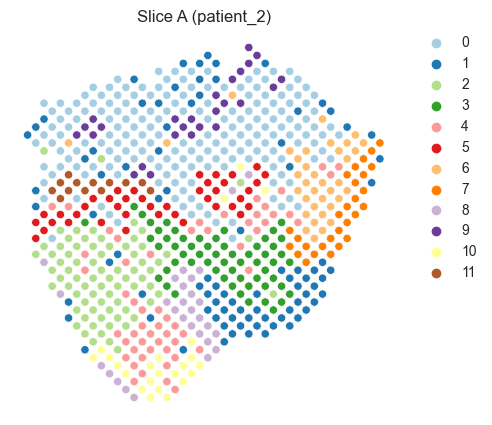

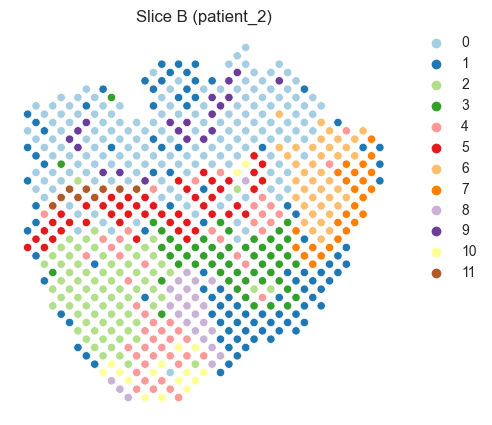

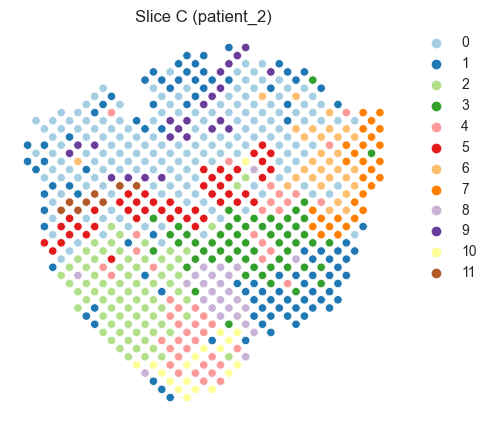

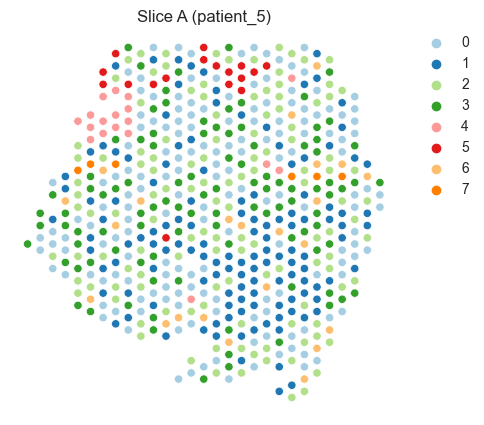

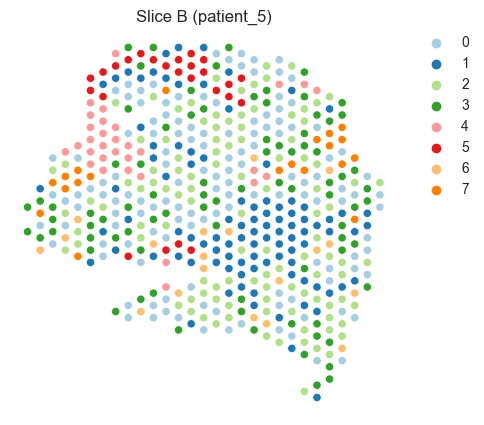

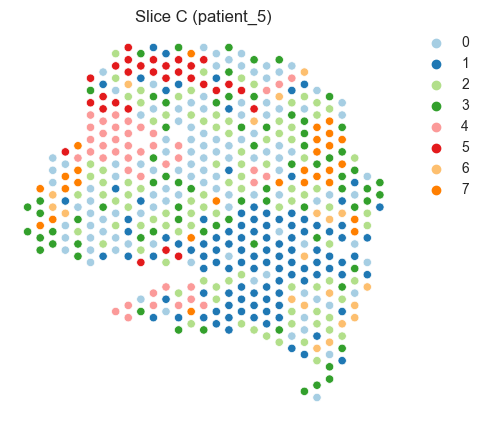

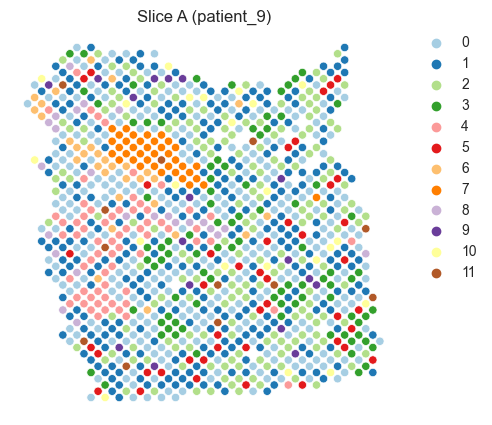

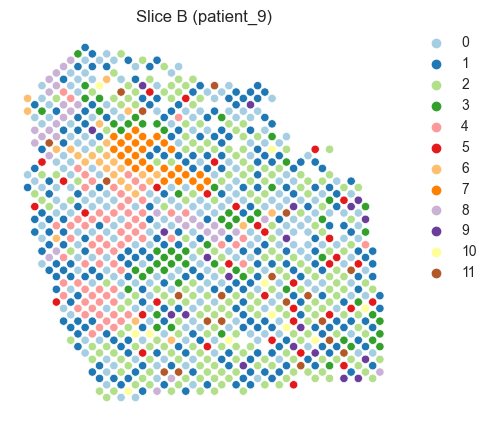

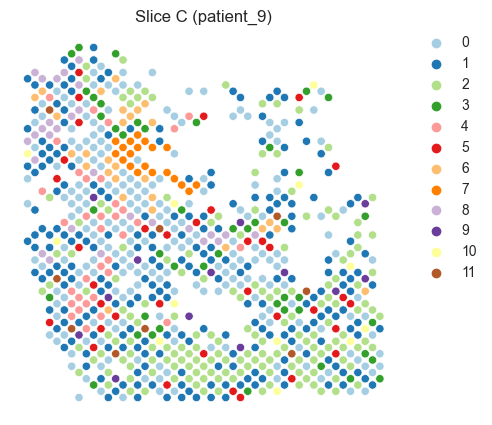

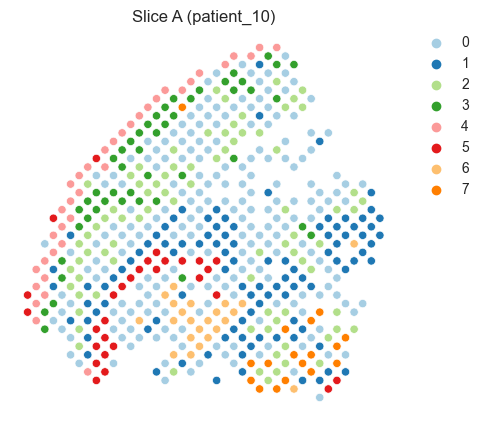

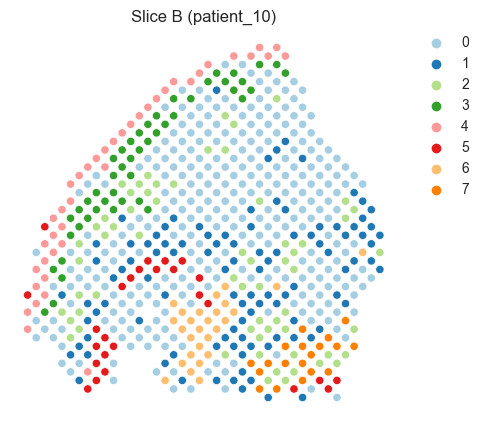

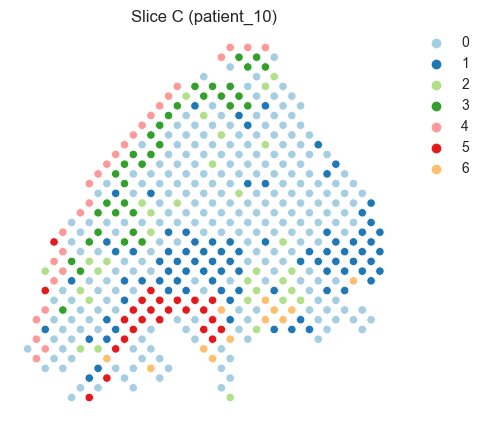

In [ ]:
for k, patient_n in patients.items():
    for adata, s in zip(patient_n, ['Slice A', 'Slice B', 'Slice C']):
        plot_clusters(adata, 'original_clusters', title = s + ' (' + k + ')')

Infer center layer via center alignment. And cache it.

In [ ]:
path_to_center_dir = path_to_output_dir + 'center_nmfs/'
if not os.path.exists(path_to_center_dir):
    os.makedirs(path_to_center_dir)

In [ ]:
saved = []
for k, patient_n in patients.items():
    initial_slice = patient_n[0].copy()
    lmbda = len(patient_n)*[1/len(patient_n)]
    center_slice, pis = pst.center_align(initial_slice, patient_n, lmbda, random_seed = 5)
    center_slice.write(path_to_center_dir + k + '_center.h5ad')
    saved.append(center_slice)

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Filtered all slices for common genes. There are 12242 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.


C:\Users\jinLab1\.conda\envs\3dreconstruction\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Objective  -142.82992357953964
Difference: 142.82992357953964

Iteration: 1
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  0.8974523031603889
Difference: 143.72737588270002

Iteration: 2
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  0.9041971493446354
Difference: 0.0067448461842464225

Iteration: 3
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  0.9037990134806517
Difference: 0.00039813586398362855

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Filtered all slices for common genes. There are 7831 common genes.
Iteration: 0
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  -191.86892353026428
Difference: 191.86892353026428

Iteration: 1
Solving Pairwise Slice Alignment Problem.
Solving Center Mapping NMF Problem.
Objective  1.3321186579219682
Difference: 193.20104218818625

Iteration: 2
Solving Pair

KeyboardInterrupt: 

Next, we run K-means cluster on the W matrix from NMF on center slice.

In [ ]:
from sklearn.cluster import KMeans

def k_means(adata, n_clusters):
    a = adata.uns['paste_W'].copy()
    a = (a.T/a.sum(axis=1)).T
    a = a + 1
    a = np.log(a)
    
    # Number of clusters is chosen to be the same as in the original clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=5).fit(a)
    l = kmeans.labels_
    return l

In [ ]:
path_to_center_dir = path_to_output_dir + 'center_nmfs/'

center_slices = {}

for k in ['patient_2', 'patient_5', 'patient_9', 'patient_10']:
    center_slice = sc.read_h5ad(path_to_center_dir + k + '_center.h5ad')
    center_slices[k] = center_slice

In [ ]:
num_clusters = {
    'patient_2' : 12,
    'patient_5' : 8,
    'patient_9' : 12,
    'patient_10' : 8
}

for k, adata in center_slices.items():
    labels = k_means(adata, num_clusters[k])
    adata.obs['kmeans'] = labels
    plot_clusters(adata, 'kmeans', title = 'Center Slice (' + k + ')')

In [ ]:
for k, adata in center_slices.items():
    adata.write(path_to_center_dir + k + '_center.h5ad')

## Calculate Spatial Coherence scores.

In [ ]:
import networkx as nx
from scipy.spatial.distance import cdist

def create_graph(adata, degree = 4):
        """
        Converts spatial coordinates into graph using networkx library.
        
        param: adata - ST Slice 
        param: degree - number of edges per vertex

        return: 1) G - networkx graph
                2) node_dict - dictionary mapping nodes to spots
        """
        D = cdist(adata.obsm['spatial'], adata.obsm['spatial'])
        # Get column indexes of the degree+1 lowest values per row
        idx = np.argsort(D, 1)[:, 0:degree+1]
        # Remove first column since it results in self loops
        idx = idx[:, 1:]

        G = nx.Graph()
        for r in range(len(idx)):
            for c in idx[r]:
                G.add_edge(r, c)

        node_dict = dict(zip(range(adata.shape[0]), adata.obs.index))
        return G, node_dict
    
def generate_graph_from_labels(adata, labels_dict):
    """
    Creates and returns the graph and dictionary {node: cluster_label} for specified layer
    """
    
    g, node_to_spot = create_graph(adata)
    spot_to_cluster = labels_dict

    # remove any nodes that are not mapped to a cluster
    removed_nodes = []
    for node in node_to_spot.keys():
        if (node_to_spot[node] not in spot_to_cluster.keys()):
            removed_nodes.append(node)

    for node in removed_nodes:
        del node_to_spot[node]
        g.remove_node(node)
        
    labels = dict(zip(g.nodes(), [spot_to_cluster[node_to_spot[node]] for node in g.nodes()]))
    return g, labels

def spatial_coherence_score(graph, labels):
    g, l = graph, labels
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
        
    return (true_entropy - np.mean(entropies))/np.std(entropies)

def spatial_entropy(g, labels):
    """
    Calculates spatial entropy of graph  
    """
    # construct contiguity matrix C which counts pairs of cluster edges
    cluster_names = np.unique(list(labels.values()))
    C = pd.DataFrame(0,index=cluster_names, columns=cluster_names)

    for e in g.edges():
        C[labels[e[0]]][labels[e[1]]] += 1

    # calculate entropy from C
    C_sum = C.values.sum()
    H = 0
    for i in range(len(cluster_names)):
        for j in range(i, len(cluster_names)):
            if (i == j):
                z = C[cluster_names[i]][cluster_names[j]]
            else:
                z = C[cluster_names[i]][cluster_names[j]] + C[cluster_names[j]][cluster_names[i]]
            if z != 0:
                H += -(z/C_sum)*math.log(z/C_sum)
    return H

Read in original data again if you need to.

In [ ]:
path_to_h5ads = path_to_output_dir + 'H5ADs/'

patient_2 = []
patient_5 = []
patient_9 = []
patient_10 = []

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for k in patients.keys():
    for i in range(3):
        patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

In [ ]:
path_to_center_dir = path_to_output_dir + 'center_nmfs/'

center_slices = {}

for k in ['patient_2', 'patient_5', 'patient_9', 'patient_10']:
    center_slice = sc.read_h5ad(path_to_center_dir + k + '_center.h5ad')
    center_slices[k] = center_slice

Calculate spatial coherence of original clusters. Uncomment out the cells below to regenerate these files. 

In [ ]:
# df = pd.DataFrame()
# for k, adata_list in patients.items():
#     print(k)
#     scores = []
#     for adata in adata_list:
#         g, l = generate_graph_from_labels(adata, adata.obs['original_clusters'])
#         scores.append(np.abs(spatial_coherence_score(g, l)))
#         print('Slice Done')
#     g, l = generate_graph_from_labels(center_slices[k], center_slices[k].obs['kmeans'])
#     scores.append(np.abs(spatial_coherence_score(g, l)))
#     print('Slice Done')
#     df[k] = scores
# df.index = ['Slice A', 'Slice B', 'Slice C', 'Center']

In [ ]:
# df

In [ ]:
#results_dir = path_to_output_dir + 'results/'

#if not os.path.exists(results_dir):
#    os.makedirs(results_dir)

In [ ]:
#df.to_csv(results_dir + 'spatial_coherence.csv')

# Note that for our plots we take the absolute value.

## Plot Spatial Coherence

In [ ]:
results_dir = path_to_output_dir + 'results/'
df = pd.read_csv(results_dir + 'spatial_coherence.csv', index_col= 0)
df = df.loc[['Center', 'Slice A', 'Slice B', 'Slice C']]
df

In [ ]:
colors = ["#41cf41", "#8766c4", "#dda0dd", "#b19cd9"]
bar_label = 4*['Center Slice','Slice A', 'Slice B', 'Slice C', ]
labels = 4*['Patient 2'] + 4*['Patient 5'] + 4*['Patient 9'] +4*['Patient 10']
zscores = []
for c in df.columns:
    zscores.append(df[c])
zscores = np.concatenate(zscores)
ax2 = sns.barplot(x=labels, y = zscores, hue=bar_label, palette=sns.color_palette(colors))
ax2.set(ylabel="|Spatial Entropy Z-Score|")
ax2.set_facecolor('white')
ax2.patch.set_edgecolor('black')
ax2.patch.set_linewidth('1')  
ax2.set_ylabel("Spatial Coherence Score", fontsize = 14)
plt.legend(frameon=True, edgecolor='black', fontsize = 12)

## Getting spatial coherence score from spatial entropy

For a given set of cluster labels, spatial coherence score is calculated by taking the std deviation from the distribution of spatial entropies generated from randomly permuting the cluster labels between spots.

In [ ]:
def get_entropy_distribution(adata, cluster_col):
    g, l = generate_graph_from_labels(adata, adata.obs[cluster_col])
    true_entropy = spatial_entropy(g, l)
    entropies = []
    for i in range(1000):
        new_l = list(l.values())
        random.shuffle(new_l)
        labels = dict(zip(l.keys(), new_l))
        entropies.append(spatial_entropy(g, labels))
    return entropies, true_entropy

In [ ]:
H5ADs_dir = path_to_output_dir + 'H5ADs/'
p2_sliceA = sc.read_h5ad(H5ADs_dir + 'patient_2_slice_0.h5ad')
p9_sliceA = sc.read_h5ad(H5ADs_dir + 'patient_9_slice_0.h5ad')

In [ ]:
p2_entropies, p2_true_entropy = get_entropy_distribution(p2_sliceA, 'original_clusters')
p9_entropies, p9_true_entropy = get_entropy_distribution(p9_sliceA, 'original_clusters')

In [ ]:
plt.figure(1)
ax = sns.distplot(p2_entropies, bins=20, kde=False)
ax.set(xlim=(3, 4.2))
ax.set_xlabel('Spatial Entropy', fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_title('Patient 2, Slice A')
plt.axvline(x=p2_true_entropy, label='Real Slice', color = "#663399" )
plt.legend(loc='upper center', fontsize = 14, frameon=True, edgecolor='black', facecolor='white')
plt.tick_params(labelsize=14)
plt.show()

plt.figure(1)
ax = sns.distplot(p9_entropies, bins=20, kde=False)
ax.set(xlim=(3, 4.2))
ax.set_xlabel('Spatial Entropy', fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_title('Patient 9, Slice A')
plt.axvline(x=p9_true_entropy, label='Real Slice', color = "#663399" )
plt.legend(loc='upper center', fontsize = 14, frameon=True, edgecolor='black', facecolor='white')
plt.tick_params(labelsize=14)
plt.show()

# Accuracy vs Spatial Coherence Plot

For each pair of consecutive slices, we plot the % preserved (pairwise experiment) vs the average spatial coherence score of the two slices (center experiment).

In [ ]:
# To avoid clutter, we run the analysis for other patients separately and read in the results
results_dir = path_to_output_dir + 'results/'
spatial_coherence_df = pd.read_csv(results_dir + 'spatial_coherence.csv', index_col= 0)
pairwise_df = pd.read_csv(results_dir + 'pairwise_results.csv', index_col = 0)

In [ ]:
spatial_coherence_df

In [ ]:
pairwise_df

For each pair of consecutive slices, we plot the proportion of clusters preserved vs the average spatial coherence of the two slices.

In [ ]:
p = np.concatenate([pairwise_df[c] for c in pairwise_df.columns])
p

In [ ]:
z = []
for c in spatial_coherence_df.columns:
    z.append(np.mean([spatial_coherence_df[c]['Slice A'], spatial_coherence_df[c]['Slice B']]))
    z.append(np.mean([spatial_coherence_df[c]['Slice B'], spatial_coherence_df[c]['Slice C']]))
z

In [ ]:
labels = 2*["Patient 2"] + 2*["Patient 5"] + 2*["Patient 9"] + 2*["Patient 10"]
palette = sns.color_palette(n_colors= 4)

ax = sns.scatterplot(np.abs(z), p, hue = labels, palette=palette, s = 120)
plt.legend(loc='lower right', frameon=True, edgecolor='black', fontsize= 14, markerscale = 1.6)
ax.set_facecolor('white')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1')  
ax.set_xlabel("Spatial Coherence Score", fontsize = 14)
ax.set_ylabel("Proportion of Spots Correctly \n Mapped within Clusters", fontsize = 14)
ax.set_ylim(-0.05, 1)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)

# Plot 3d

Read in data

In [49]:
path_to_h5ads = path_to_output_dir + 'H5ADs/'

patient_2 = []
patient_5 = []
patient_9 = []
patient_10 = []

patients = {
    "patient_2" : patient_2,
    "patient_5" : patient_5,
    "patient_9" : patient_9,
    "patient_10" : patient_10,
}

for k in patients.keys():
    for i in range(3):
        patients[k].append(sc.read_h5ad(path_to_h5ads + k + '_slice_' + str(i) + '.h5ad'))

Run pairwise align and calculate alignment based on pis

In [21]:
import plotly.express as px
import plotly.io as pio
import warnings
import plotly.graph_objects as go

In [38]:
patient_n[0].obsm["spatial"]

array([[ 7, 45],
       [ 8, 30],
       [ 8, 32],
       ...,
       [49, 45],
       [50, 42],
       [50, 44]], dtype=int64)

In [52]:
for k, patient_n in patients.items():
# for k, patient_n in patients.items():
    pi12 = pst.pairwise_align(patient_n[0].copy(), patient_n[1].copy(), alpha = 0.1)
    pi23 = pst.pairwise_align(patient_n[1].copy(), patient_n[2].copy(), alpha = 0.1)
    pis = [pi12, pi23]
    new_slices = pst.stack_slices_pairwise(patient_n, pis)
    
    for i,L in enumerate(new_slices):
        diopy.output.write_h5(L,file= (H5ADs_dir + k + '_slice_' + str(i) + '.h5'))
    
    # # Plot 3d
    # warnings.filterwarnings("ignore")
    # ## comment out the following line and uncomment out the line below the next if you use jupyterlab instead jupyter notebooks.
    # pio.renderers.default='notebook'
    # #pio.renderers.default='jupyterlab' 
    # slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    # # scale the distance between layers
    # z_scale = 10

    # df = pd.DataFrame(columns=['x','y','z','layer'])

    # clusters = []
    # for i,L in enumerate(new_slices):
    #     for x,y in L.obsm['spatial']:
    #         df = df._append({'x': x,'y':y,'z':i*z_scale,'slice':str(i)}, ignore_index=True)

    #     clusters.append(np.array(L.obs['original_clusters']))
    # clusters = np.concatenate(clusters)
    # df['clusters'] = clusters
    # fig = px.scatter_3d(df, x='x', y='y', z='z',color='clusters', title = k)
    # # fig = go.Figure(data=go.Scatter3d())
    # fig.update_layout(scene_aspectmode='data')
    # fig.show()

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Error: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Error: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
Error: module 'numpy' has no att

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50150150e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.45261541e-03, 4.88860954e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.50150150e-03]])

In [30]:
new_slices[0].obsm["spatial"]

array([[-20.1966967 ,   9.77027027],
       [-19.1966967 ,  -5.22972973],
       [-19.1966967 ,  -3.22972973],
       ...,
       [ 21.8033033 ,   9.77027027],
       [ 22.8033033 ,   6.77027027],
       [ 22.8033033 ,   8.77027027]])

In [ ]:
import plotly.express as px
df = px.data.gapminder().query("continent=='Europe'")
fig = px.line_3d(df, x="gdpPercap", y="pop", z="year", color='country')
fig.show()

In [ ]:
df.head(5)

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
12,Albania,Europe,1952,55.23,1282697,1601.056136,ALB,8
13,Albania,Europe,1957,59.28,1476505,1942.284244,ALB,8
14,Albania,Europe,1962,64.82,1728137,2312.888958,ALB,8
15,Albania,Europe,1967,66.22,1984060,2760.196931,ALB,8
16,Albania,Europe,1972,67.69,2263554,3313.422188,ALB,8


1. 查看seurat（R中的anndata）如何存储空间转录组多切片数据
2. R语言如何画3d的plotly图像
3. 看完文献2